# NLP - Sentiment Analysis

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

# Importing the Dependencies:

In [2]:
# Basic Libraries for Machine Learning
import pandas as pd
import numpy as np

# For Date Visualization and EDA
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from collections import Counter
from transformers import BertTokenizer
from collections import Counter
import torch
import tensorflow
import keras
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.optimizers import Adam
from torch.nn.utils.rnn import pad_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import GRU
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# Data Collection and Pre-Processing:

In [ ]:
# loading the datset in pandas dataframe
df=pd.read_csv('/content/Reviews.csv')

In [ ]:
# number of row and columns
print(df.shape)

(100173, 10)


In [ ]:
# Checking the null values
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               4
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [ ]:
# Droping the null value rows
df=df.dropna()

In [ ]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [ ]:
# Taking sample
df=df.sample(43000)
data=df

In [ ]:
data.to_csv("sample.csv")

In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
pip install wordcloud

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Exploratory Data Analysis (EDA):

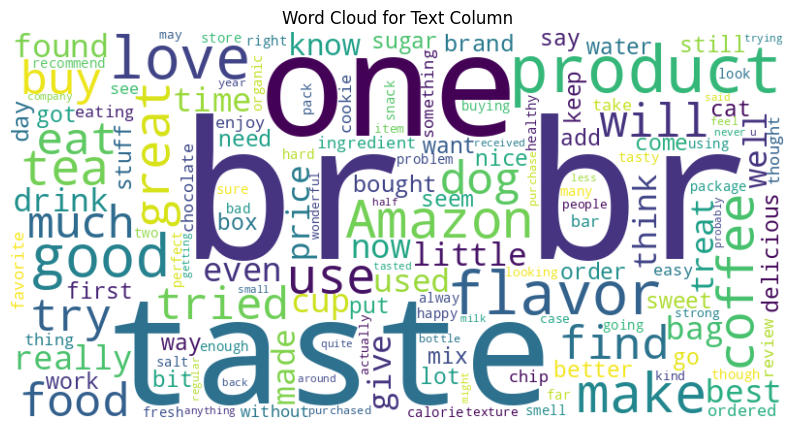

In [ ]:
data['TextLength'] = data['Text'].apply(lambda x: len(word_tokenize(str(x))))

# Word Cloud for Text Column
wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(data['Text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text Column')
plt.show()

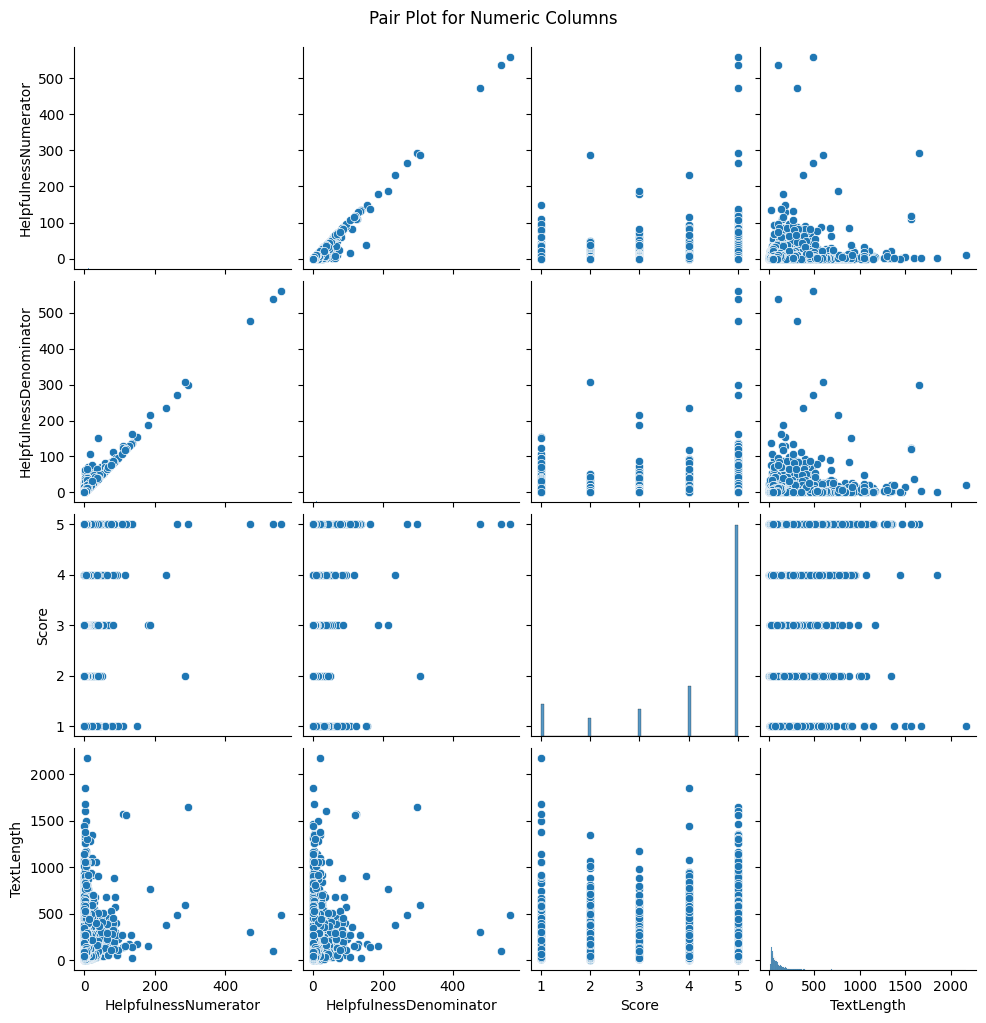

In [ ]:
# Pair Plot for Numeric Columns
sns.pairplot(data[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'TextLength']])
plt.suptitle('Pair Plot for Numeric Columns', y=1.02)
plt.show()

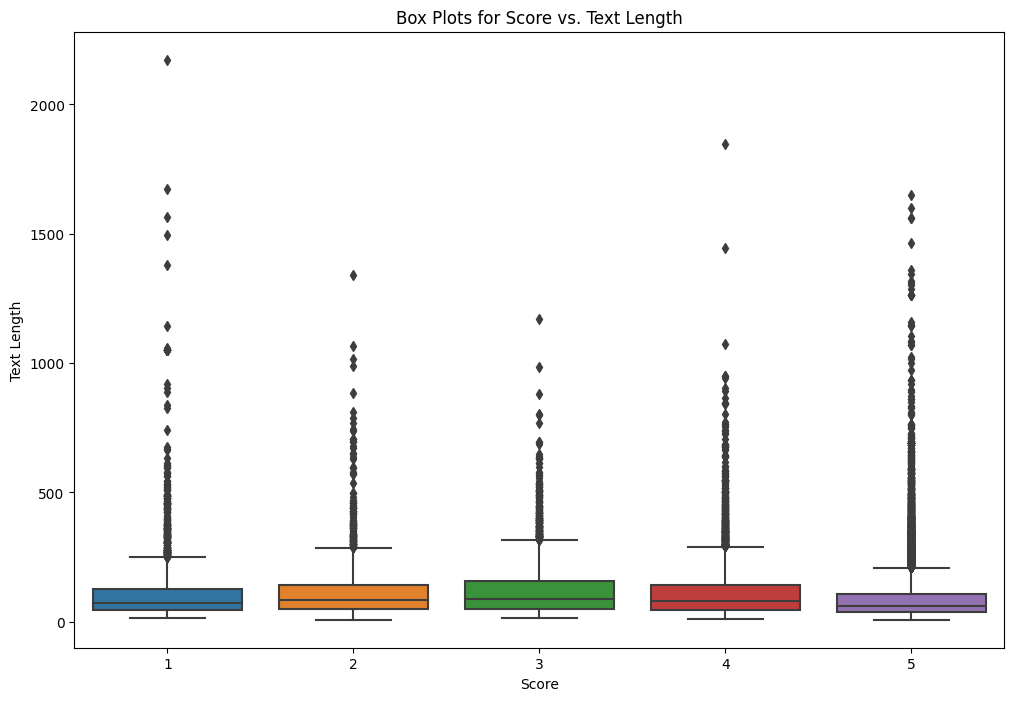

In [ ]:
# Box Plots for Score vs. Text Length
plt.figure(figsize=(12, 8))
sns.boxplot(x='Score', y='TextLength', data=data)
plt.title('Box Plots for Score vs. Text Length')
plt.xlabel('Score')
plt.ylabel('Text Length')
plt.show()

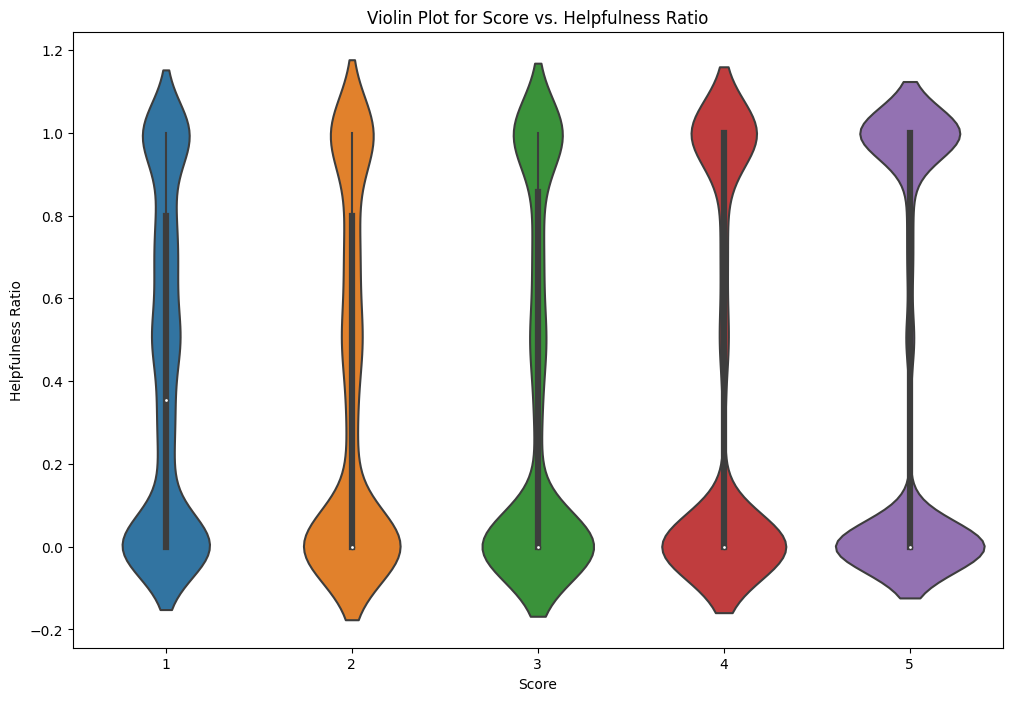

In [ ]:
# Create HelpfulnessRatio column
data['HelpfulnessRatio'] = data['HelpfulnessNumerator'] / data['HelpfulnessDenominator']
data['HelpfulnessRatio'].fillna(0, inplace=True)  # Handle potential division by zero

# Violin Plot for Score vs. Helpfulness Ratio
plt.figure(figsize=(12, 8))
sns.violinplot(x='Score', y='HelpfulnessRatio', data=data)
plt.title('Violin Plot for Score vs. Helpfulness Ratio')
plt.xlabel('Score')
plt.ylabel('Helpfulness Ratio')
plt.show()

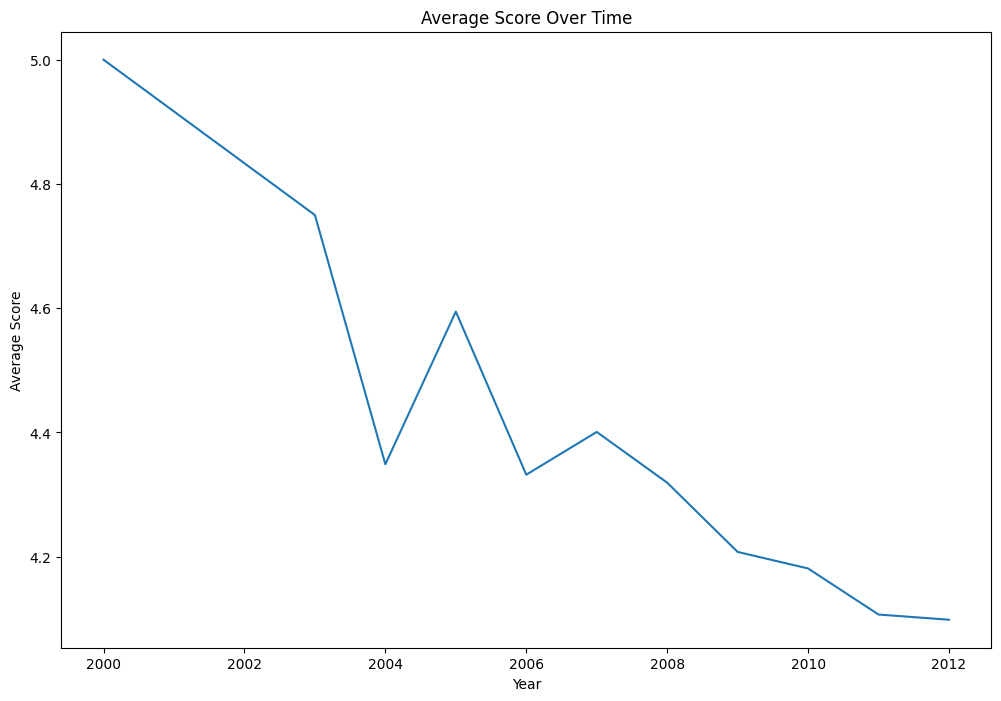

In [ ]:
# Time Series Analysis for Scores Over Time
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data['Year'] = data['Time'].dt.year
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Score', data=data.groupby('Year')['Score'].mean().reset_index())
plt.title('Average Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.show()

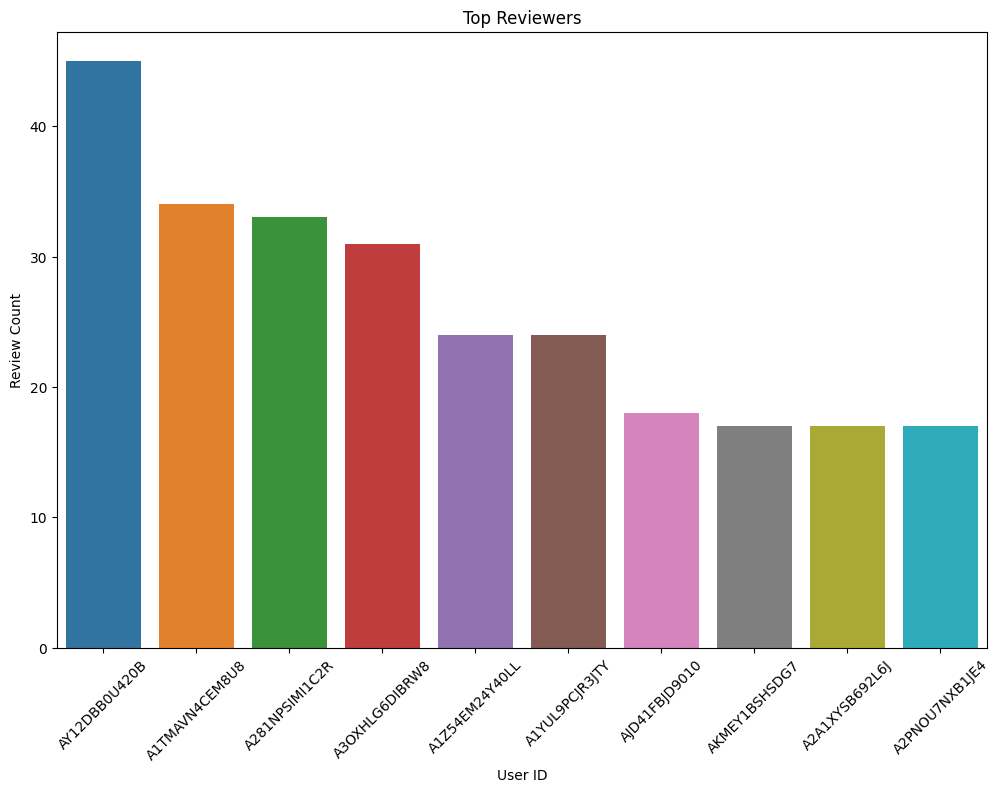

<Figure size 640x480 with 0 Axes>

In [ ]:
# Bar Plot for Top Reviewers (UserId with highest review count)
top_reviewers = data['UserId'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_reviewers.index, y=top_reviewers.values)
plt.title('Top Reviewers')
plt.xlabel('User ID')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.show()
plt.savefig('barplot.jpg')

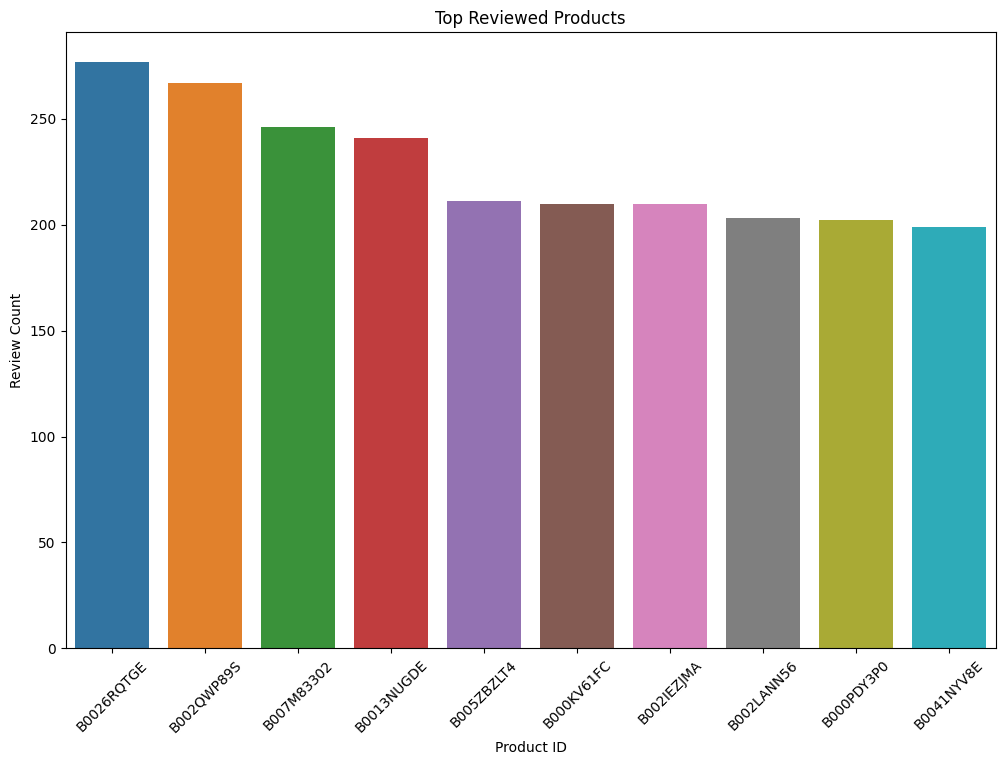

In [ ]:
# Bar Plot for Top Reviewed Products (ProductId with highest review count)
top_products = data['ProductId'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.show()

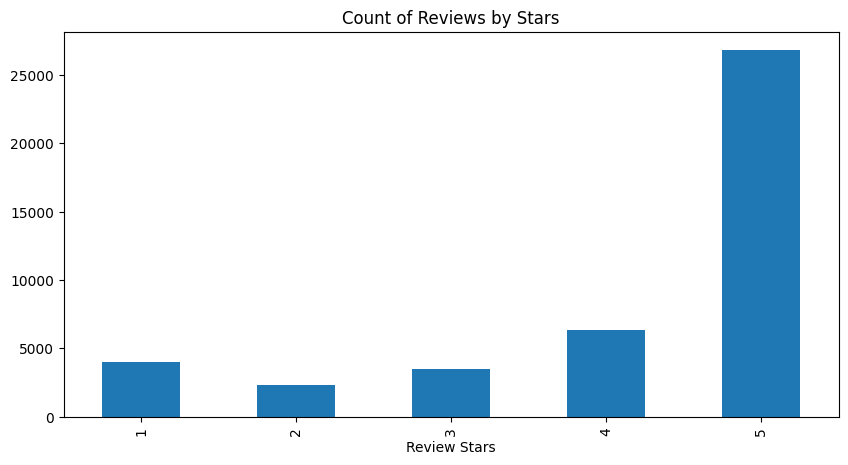

<Figure size 640x480 with 0 Axes>

In [ ]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()
plt.savefig('Count of Reviews by Stars')

The most commonly used is the Pearson Correlation method.

In [ ]:
correlation=df.corr(method='pearson')

<ipython-input-24-19277ba4b80a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation=df.corr(method='pearson')


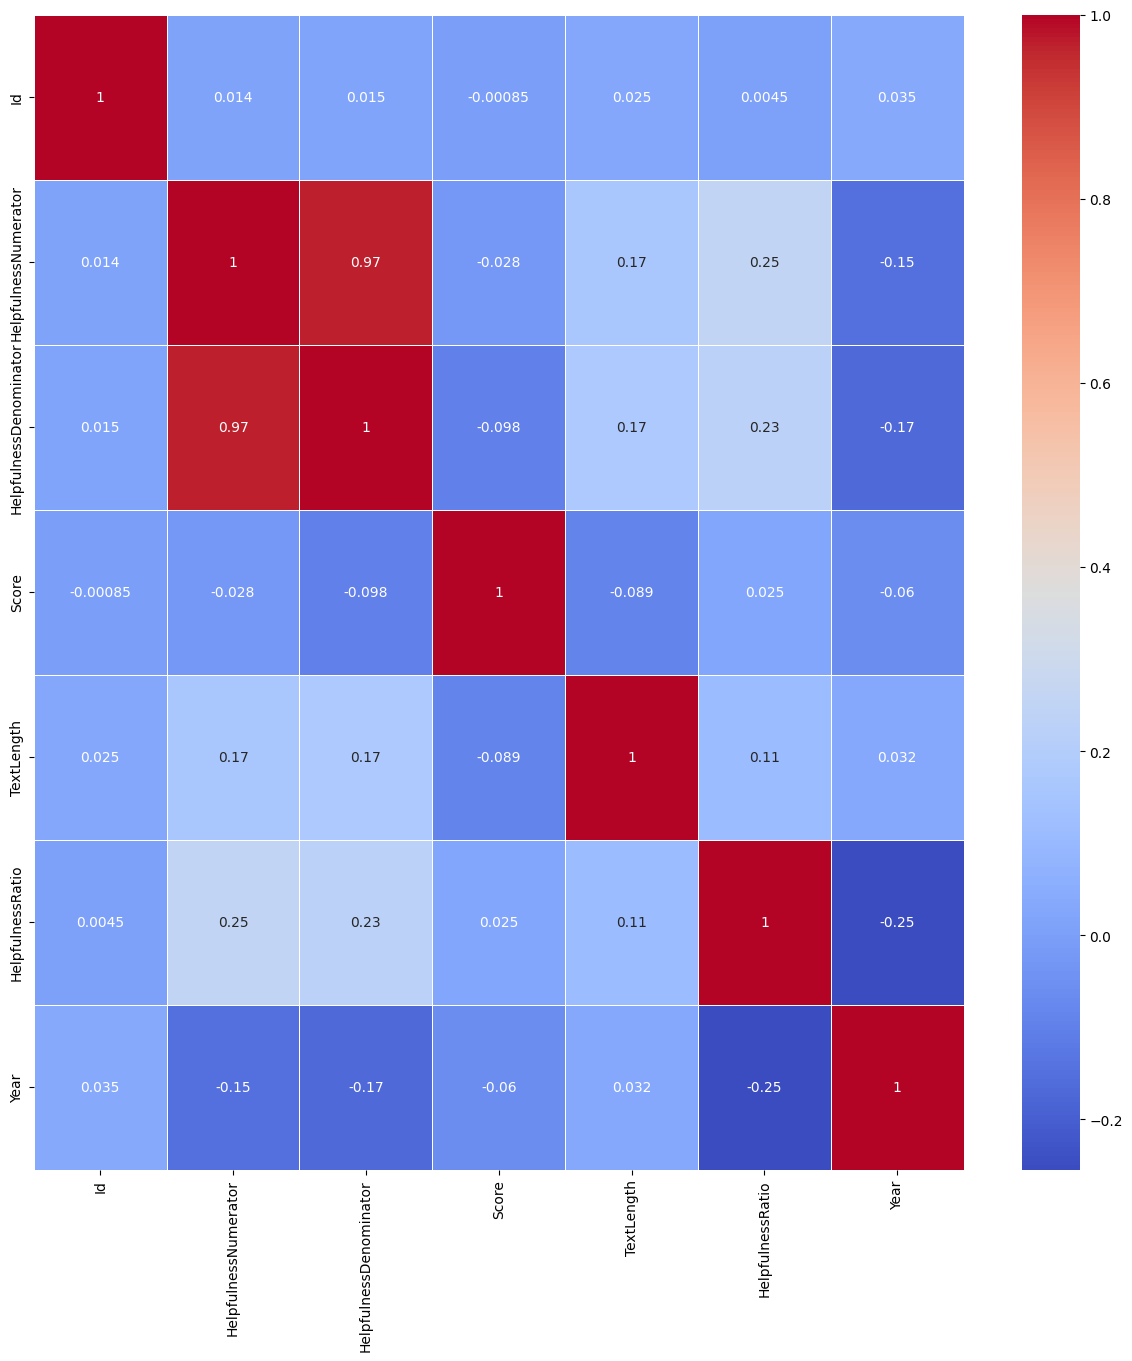

In [ ]:
# Heatmap for Correlation Between Review Length and Helpfulness Ratio
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.savefig('Corrleation.png')
plt.show()

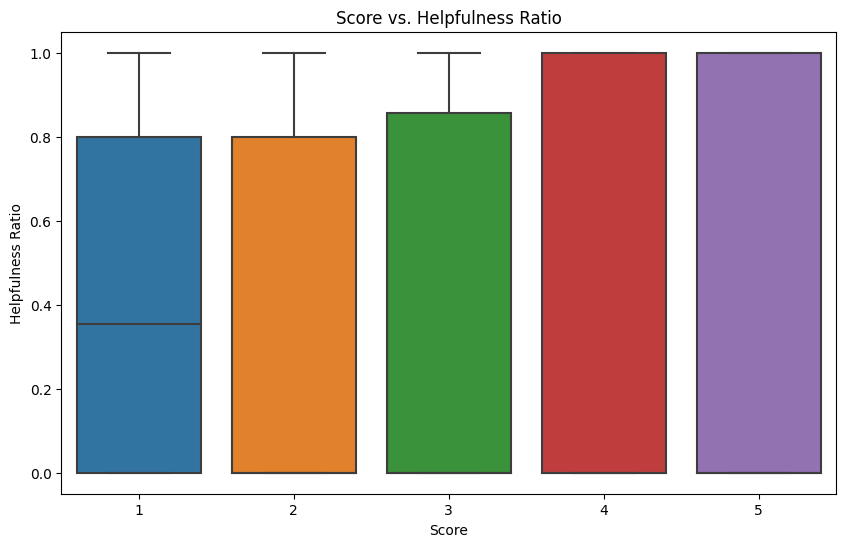

In [ ]:
# Categorical Plot for Score vs. Helpfulness Ratio
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='HelpfulnessRatio', data=data)
plt.title('Score vs. Helpfulness Ratio')
plt.xlabel('Score')
plt.ylabel('Helpfulness Ratio')
plt.show()

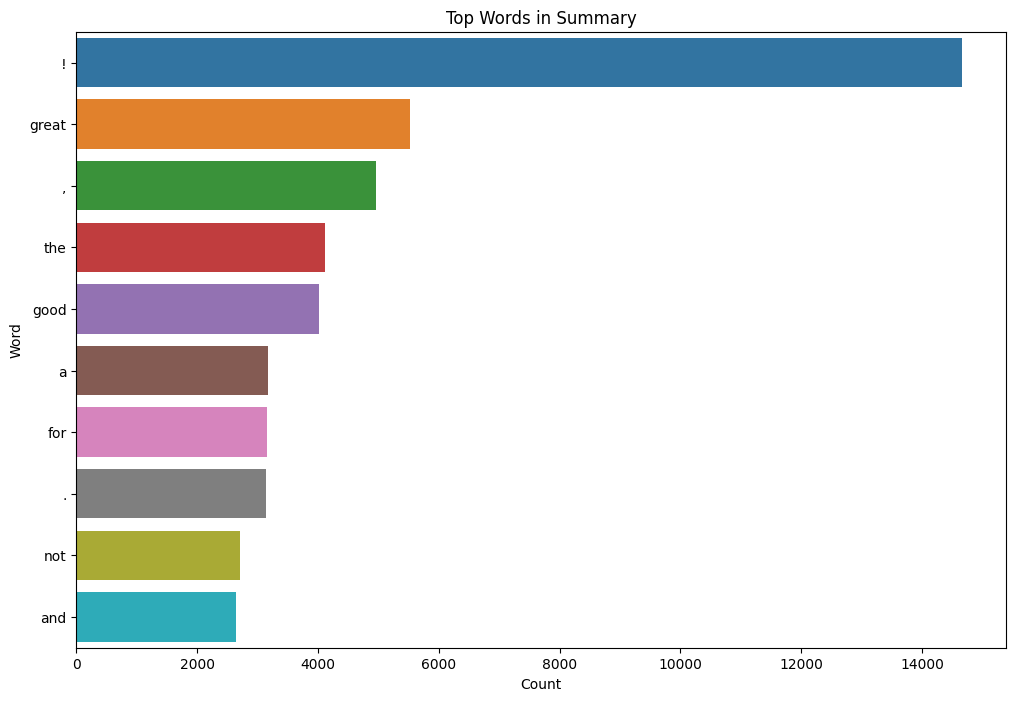

In [ ]:
# Count Plot for Top Words in Summary

top_words_summary = Counter([word for words in data['Summary'].dropna() for word in word_tokenize(words.lower())]).most_common(10)
top_words_summary_df = pd.DataFrame(top_words_summary, columns=['Word', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=top_words_summary_df)
plt.title('Top Words in Summary')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Model Architecture:

# LSTM:

LSTM stands for Long-Short Term Memory, and it is a type of recurrent neural network (RNN) architecture, which is a class of artificial neural networks designed for sequential data processing. LSTMs were introduced to address some of the limitations of traditional RNNs in learning and remembering long-term dependencies in sequential data.

The key innovation of LSTM networks is the incorporation of memory cells and a gating mechanism that regulates the flow of information into and out of these cells. The key innovation of LSTM networks is the incorporation of memory cells and a gating mechanism that regulates the flow of information into and out of these cells. The architecture includes three main components:

1. Cell state

2. Hidden state

3. Output

## Approach - 1:

In [ ]:
df = pd.read_csv('/content/sample.csv')

# Load pre-trained model tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['Text'])

# Convert text to sequences
x_train = tokenizer.texts_to_sequences(df['Text'])

# Pad sequences to a uniform length
x_train = pad_sequences(x_train, maxlen=512, padding='post', dtype='int32')

# Decrement the score column values by 1
df['Score'] = df['Score'] - 1

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_train, df['Score'], test_size=0.2, random_state=42, shuffle=True)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=512))

model.add(LSTM(128, input_shape=(128, 1)))

# Add Dense layers
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 128)          5313920   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 5454085 (20.81 MB)
Trainable params: 5454085 (20.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the model
history_1 = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=.1)

Epoch 1/10
242/242 [==============================] - 15s 64ms/step - loss: 1.1651 - accuracy: 0.6225 - val_loss: 1.1379 - val_accuracy: 0.6358
Epoch 2/10
242/242 [==============================] - 13s 55ms/step - loss: 1.1641 - accuracy: 0.6225 - val_loss: 1.1404 - val_accuracy: 0.6358
Epoch 3/10
242/242 [==============================] - 12s 51ms/step - loss: 1.1632 - accuracy: 0.6225 - val_loss: 1.1425 - val_accuracy: 0.6358
Epoch 4/10
242/242 [==============================] - 12s 49ms/step - loss: 1.1636 - accuracy: 0.6225 - val_loss: 1.1461 - val_accuracy: 0.6358
Epoch 5/10
242/242 [==============================] - 10s 41ms/step - loss: 1.1622 - accuracy: 0.6225 - val_loss: 1.1397 - val_accuracy: 0.6358
Epoch 6/10
242/242 [==============================] - 11s 47ms/step - loss: 1.1623 - accuracy: 0.6225 - val_loss: 1.1414 - val_accuracy: 0.6358
Epoch 7/10
242/242 [==============================] - 10s 40ms/step - loss: 1.1627 - accuracy: 0.6225 - val_loss: 1.1408 - val_accuracy:

In the above code we used normal tokenizer pre-trained from keras with adam optimizer, loss as categorical entropy with sigmoid activation function.

## Approach - 2:

In [ ]:
df = pd.read_csv('/content/sample.csv')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=512)
    return np.asarray(tokens).astype('int32')

# Apply the tokenizer to the text column
df['text_tokens'] = df['Text'].apply(tokenize_text)

# Decrement the score column values by 1
df['Score'] = df['Score'] - 1

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df['text_tokens'], df['Score'], test_size=0.2, random_state=42, shuffle=True)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Pad sequences to a uniform length
x_train = pad_sequences(x_train, maxlen=512, padding='post', dtype='int32')

# Build the model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=128, input_length=512))

model.add(LSTM(128, input_shape=(128, 1)))

# Add Dense layers
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 128)          3906816   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4046981 (15.44 MB)
Trainable params: 4046981 (15.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the model
history_2 = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=.1)

Epoch 1/10
242/242 [==============================] - 33s 123ms/step - loss: 1.1868 - accuracy: 0.6205 - val_loss: 1.1393 - val_accuracy: 0.6358
Epoch 2/10
242/242 [==============================] - 22s 89ms/step - loss: 1.1700 - accuracy: 0.6225 - val_loss: 1.1372 - val_accuracy: 0.6358
Epoch 3/10
242/242 [==============================] - 16s 68ms/step - loss: 1.1686 - accuracy: 0.6225 - val_loss: 1.1383 - val_accuracy: 0.6358
Epoch 4/10
242/242 [==============================] - 14s 56ms/step - loss: 1.1681 - accuracy: 0.6225 - val_loss: 1.1369 - val_accuracy: 0.6358
Epoch 5/10
242/242 [==============================] - 13s 55ms/step - loss: 1.1667 - accuracy: 0.6225 - val_loss: 1.1393 - val_accuracy: 0.6358
Epoch 6/10
242/242 [==============================] - 11s 45ms/step - loss: 1.1662 - accuracy: 0.6225 - val_loss: 1.1400 - val_accuracy: 0.6358
Epoch 7/10
242/242 [==============================] - 11s 46ms/step - loss: 1.1666 - accuracy: 0.6225 - val_loss: 1.1371 - val_accuracy

In the above code we used BERT Tokenizer, took adam optimizer, loss as categorical crossentropy with sigmoid as activation function

## Approach - 3:

In [ ]:
df = pd.read_csv('/content/sample.csv')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=512)
    return np.asarray(tokens).astype('int32')

# Apply the tokenizer to the text column
df['text_tokens'] = df['Text'].apply(tokenize_text)

# Decrement the score column values by 1
df['Score'] = df['Score'] - 1

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df['text_tokens'], df['Score'], test_size=0.2, random_state=42, shuffle=True)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Pad sequences to a uniform length
x_train = pad_sequences(x_train, maxlen=512, padding='post', dtype='int32')

# Build the model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=128, input_length=512))

model.add(LSTM(128, input_shape=(128, 1)))

# Add Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 128)          3906816   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4046981 (15.44 MB)
Trainable params: 4046981 (15.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the model
history_3 = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 30s 125ms/step - loss: 0.1175 - accuracy: 0.6196 - val_loss: 0.1127 - val_accuracy: 0.6311
Epoch 2/10
215/215 [==============================] - 19s 88ms/step - loss: 0.1156 - accuracy: 0.6220 - val_loss: 0.1126 - val_accuracy: 0.6311
Epoch 3/10
215/215 [==============================] - 15s 67ms/step - loss: 0.1153 - accuracy: 0.6229 - val_loss: 0.1126 - val_accuracy: 0.6304
Epoch 4/10
215/215 [==============================] - 14s 65ms/step - loss: 0.1147 - accuracy: 0.6237 - val_loss: 0.1129 - val_accuracy: 0.6304
Epoch 5/10
215/215 [==============================] - 12s 57ms/step - loss: 0.1146 - accuracy: 0.6243 - val_loss: 0.1128 - val_accuracy: 0.6311
Epoch 6/10
215/215 [==============================] - 10s 48ms/step - loss: 0.1141 - accuracy: 0.6250 - val_loss: 0.1129 - val_accuracy: 0.6301
Epoch 7/10
215/215 [==============================] - 11s 49ms/step - loss: 0.1141 - accuracy: 0.6258 - val_loss: 0.1129 - val_accuracy

In the above code we changed the activation function from sigmoid to relu and loss from categorical crossentropy to mean squared error

## Plotting and result:

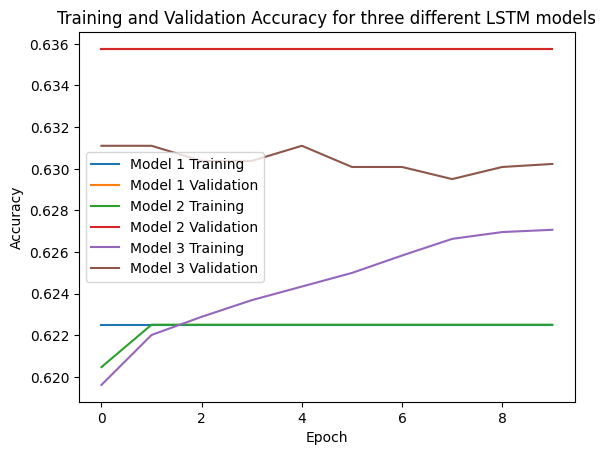

In [ ]:
# Plotting
plt.plot(history_1.history['accuracy'], label='Model 1 Training')
plt.plot(history_1.history['val_accuracy'], label='Model 1 Validation')

plt.plot(history_2.history['accuracy'], label='Model 2 Training')
plt.plot(history_2.history['val_accuracy'], label='Model 2 Validation')

plt.plot(history_3.history['accuracy'], label='Model 3 Training')
plt.plot(history_3.history['val_accuracy'], label='Model 3 Validation')

plt.title('Training and Validation Accuracy for three different LSTM models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# GRU:

GRU stands for Gated Recurrent Unit. GRU is an extension of the traditional RNN and is designed to address some of its limitations, particularly in dealing with long-range dependencies and vanishing/exploding gradient problems. The key innovation of GRU lies in its gating mechanism, which allows the network to selectively update and reset its hidden state. The GRU cell typically contains two gates: the "update gate" and the "reset gate." These gates control the flow of information within the network, enabling it to decide what information to keep or discard from the past.

## Approach - 1:

In [ ]:
df = pd.read_csv('/content/sample.csv')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=512)
    return np.asarray(tokens).astype('int32')

# Apply the tokenizer to the text column
df['text_tokens'] = df['Text'].apply(tokenize_text)

# Decrement the score column values by 1
df['Score'] = df['Score'] - 1

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df['text_tokens'], df['Score'], test_size=0.2, random_state=42, shuffle=True)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Pad sequences to a uniform length
x_train = pad_sequences(x_train, maxlen=512, padding='post', dtype='int32')

# Build the model with changes
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=128, input_length=512))

# Replace LSTM with GRU layer
model.add(GRU(128, input_shape=(128, 1)))

# Change Dense layer activation to 'relu'
model.add(Dense(64, activation='relu'))

# Change the Dropout rate
model.add(Dropout(0.5))

# Change the output Dense layer activation to 'softmax'
model.add(Dense(5, activation='softmax'))

# Change optimizer to RMSprop
model.compile(optimizer=RMSprop(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 512, 128)          3906816   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4014469 (15.31 MB)
Trainable params: 4014469 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the model
history1_GRU = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 22s 88ms/step - loss: 0.1200 - accuracy: 0.6189 - val_loss: 0.1129 - val_accuracy: 0.6311
Epoch 2/10
215/215 [==============================] - 14s 63ms/step - loss: 0.1167 - accuracy: 0.6220 - val_loss: 0.1126 - val_accuracy: 0.6311
Epoch 3/10
215/215 [==============================] - 11s 52ms/step - loss: 0.1162 - accuracy: 0.6220 - val_loss: 0.1126 - val_accuracy: 0.6311
Epoch 4/10
215/215 [==============================] - 9s 41ms/step - loss: 0.1156 - accuracy: 0.6220 - val_loss: 0.1129 - val_accuracy: 0.6311
Epoch 5/10
215/215 [==============================] - 10s 46ms/step - loss: 0.1155 - accuracy: 0.6220 - val_loss: 0.1130 - val_accuracy: 0.6311
Epoch 6/10
215/215 [==============================] - 10s 46ms/step - loss: 0.1155 - accuracy: 0.6220 - val_loss: 0.1125 - val_accuracy: 0.6311
Epoch 7/10
215/215 [==============================] - 8s 37ms/step - loss: 0.1154 - accuracy: 0.6220 - val_loss: 0.1126 - val_accuracy: 0

In the above code we used GRU model with BERT Tokenizer, optimizer as RMSprop, loss as mean squared error with relu activation function

## Approach - 2:

In [ ]:
df = pd.read_csv('/content/sample.csv')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=512)
    return np.asarray(tokens).astype('int32')

# Apply the tokenizer to the text column
df['text_tokens'] = df['Text'].apply(tokenize_text)

# Decrement the score column values by 1
df['Score'] = df['Score'] - 1

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df['text_tokens'], df['Score'], test_size=0.2, random_state=42, shuffle=True)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Pad sequences to a uniform length
x_train = pad_sequences(x_train, maxlen=512, padding='post', dtype='int32')

# Build the model with changes
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=128, input_length=512))

# Replace LSTM with GRU layer
model.add(GRU(128, input_shape=(128, 1)))

# Change Dense layer activation to 'relu'
model.add(Dense(64, activation='relu'))

# Change the Dropout rate
model.add(Dropout(0.5))

# Change the output Dense layer activation to 'softmax'
model.add(Dense(5, activation='softmax'))

# Change optimizer to Adam
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 512, 128)          3906816   
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4014469 (15.31 MB)
Trainable params: 4014469 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the model
history2_GRU = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 29s 125ms/step - loss: 1.2138 - accuracy: 0.6182 - val_loss: 1.1500 - val_accuracy: 0.6311
Epoch 2/10
215/215 [==============================] - 18s 83ms/step - loss: 1.1837 - accuracy: 0.6220 - val_loss: 1.1444 - val_accuracy: 0.6311
Epoch 3/10
215/215 [==============================] - 15s 69ms/step - loss: 1.1795 - accuracy: 0.6222 - val_loss: 1.1463 - val_accuracy: 0.6311
Epoch 4/10
215/215 [==============================] - 14s 64ms/step - loss: 1.1751 - accuracy: 0.6232 - val_loss: 1.1654 - val_accuracy: 0.6311
Epoch 5/10
215/215 [==============================] - 11s 52ms/step - loss: 1.1700 - accuracy: 0.6242 - val_loss: 1.1459 - val_accuracy: 0.6304
Epoch 6/10
215/215 [==============================] - 10s 48ms/step - loss: 1.1654 - accuracy: 0.6252 - val_loss: 1.1524 - val_accuracy: 0.6295
Epoch 7/10
215/215 [==============================] - 10s 45ms/step - loss: 1.1601 - accuracy: 0.6263 - val_loss: 1.1577 - val_accuracy

In the above code we changed the optimizer from RMSprop to Adam and loss from mean squared error to categorical cross entropy

## Plotting and result:

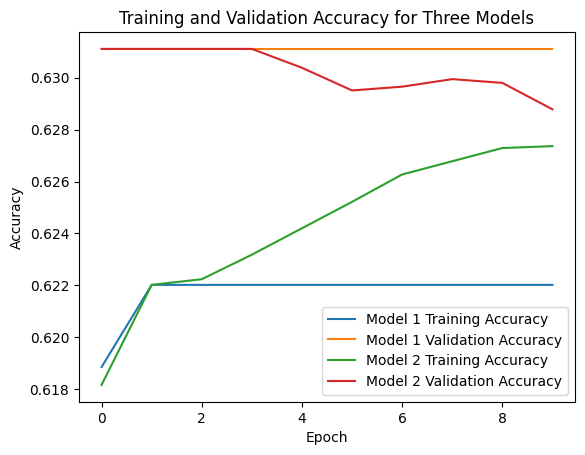

In [ ]:
# Plotting
plt.plot(history1_GRU.history['accuracy'], label='Model 1 Training Accuracy')
plt.plot(history1_GRU.history['val_accuracy'], label='Model 1 Validation Accuracy')

plt.plot(history2_GRU.history['accuracy'], label='Model 2 Training Accuracy')
plt.plot(history2_GRU.history['val_accuracy'], label='Model 2 Validation Accuracy')

# Add lines for the third model if available
# plt.plot(history3.history['accuracy'], label='Model 3 Training Accuracy')
# plt.plot(history3.history['val_accuracy'], label='Model 3 Validation Accuracy')

plt.title('Training and Validation Accuracy for Three Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Contributions:

Apu Chakraborty (20053) - Data Collection and Pre-Processing, LSTM model training and plotting the result

Vimaleswar A (20305) - Exploratory Data Analysis, GRU model training and plotting the result

Presentation made by both